In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
'''
Here we are combining all the ticker files into one file and loading into a dataframe. Also created a new column 'Daily Return'
by calculating the percentage changes in 'Adj Close'
'''
directory = r"/Users/rahulpayeli/Documents/DataMining/Project/data"

combined_dfs = []

# Iterate over files in directory
for file in os.listdir(directory):
    df = pd.read_csv(f'/Users/rahulpayeli/Documents/DataMining/Project/data/{file}')
    if not df.empty:
        df = df.iloc[:,1:]
        
        #create a new column called 'Daily Return', that holds percentage change in the 'Adj Close'.
        df['Daily Return'] = df['Adj Close'].pct_change().fillna(0)
        combined_dfs.append(df)

combined_data = pd.concat(combined_dfs, ignore_index=True)
print(combined_data.head())

                    Datetime      Open      High       Low     Close  \
0  2023-09-30 19:00:00+00:00  0.362667  0.362677  0.362304  0.362304   
1  2023-09-30 20:00:00+00:00  0.362282  0.362500  0.362046  0.362260   
2  2023-09-30 21:00:00+00:00  0.362293  0.362526  0.361772  0.361772   
3  2023-09-30 22:00:00+00:00  0.361661  0.362372  0.361661  0.362299   
4  2023-09-30 23:00:00+00:00  0.362343  0.363163  0.362226  0.362613   

   Adj Close  Volume   ticker  Daily Return  
0   0.362304       0  ELF-USD      0.000000  
1   0.362260       0  ELF-USD     -0.000120  
2   0.361772       0  ELF-USD     -0.001348  
3   0.362299       0  ELF-USD      0.001456  
4   0.362613       0  ELF-USD      0.000866  


ticker                     1000SATS-USD  1INCH-USD  AAVE-USD   ADA-USD  \
Datetime                                                                 
2023-09-30 19:00:00+00:00           0.0   0.000000  0.000000  0.000000   
2023-09-30 20:00:00+00:00           0.0  -0.001576 -0.000387  0.000042   
2023-09-30 21:00:00+00:00           0.0   0.000564 -0.001030 -0.001511   
2023-09-30 22:00:00+00:00           0.0   0.003619  0.001602  0.000396   
2023-09-30 23:00:00+00:00           0.0  -0.003125 -0.004472  0.001078   

ticker                     AERO29270-USD  AEVO-USD  AIOZ-USD   AKT-USD  \
Datetime                                                                 
2023-09-30 19:00:00+00:00            0.0       0.0  0.000000  0.000000   
2023-09-30 20:00:00+00:00            0.0       0.0 -0.003363  0.003019   
2023-09-30 21:00:00+00:00            0.0       0.0 -0.000085  0.001081   
2023-09-30 22:00:00+00:00            0.0       0.0 -0.003145 -0.000825   
2023-09-30 23:00:00+00:00            

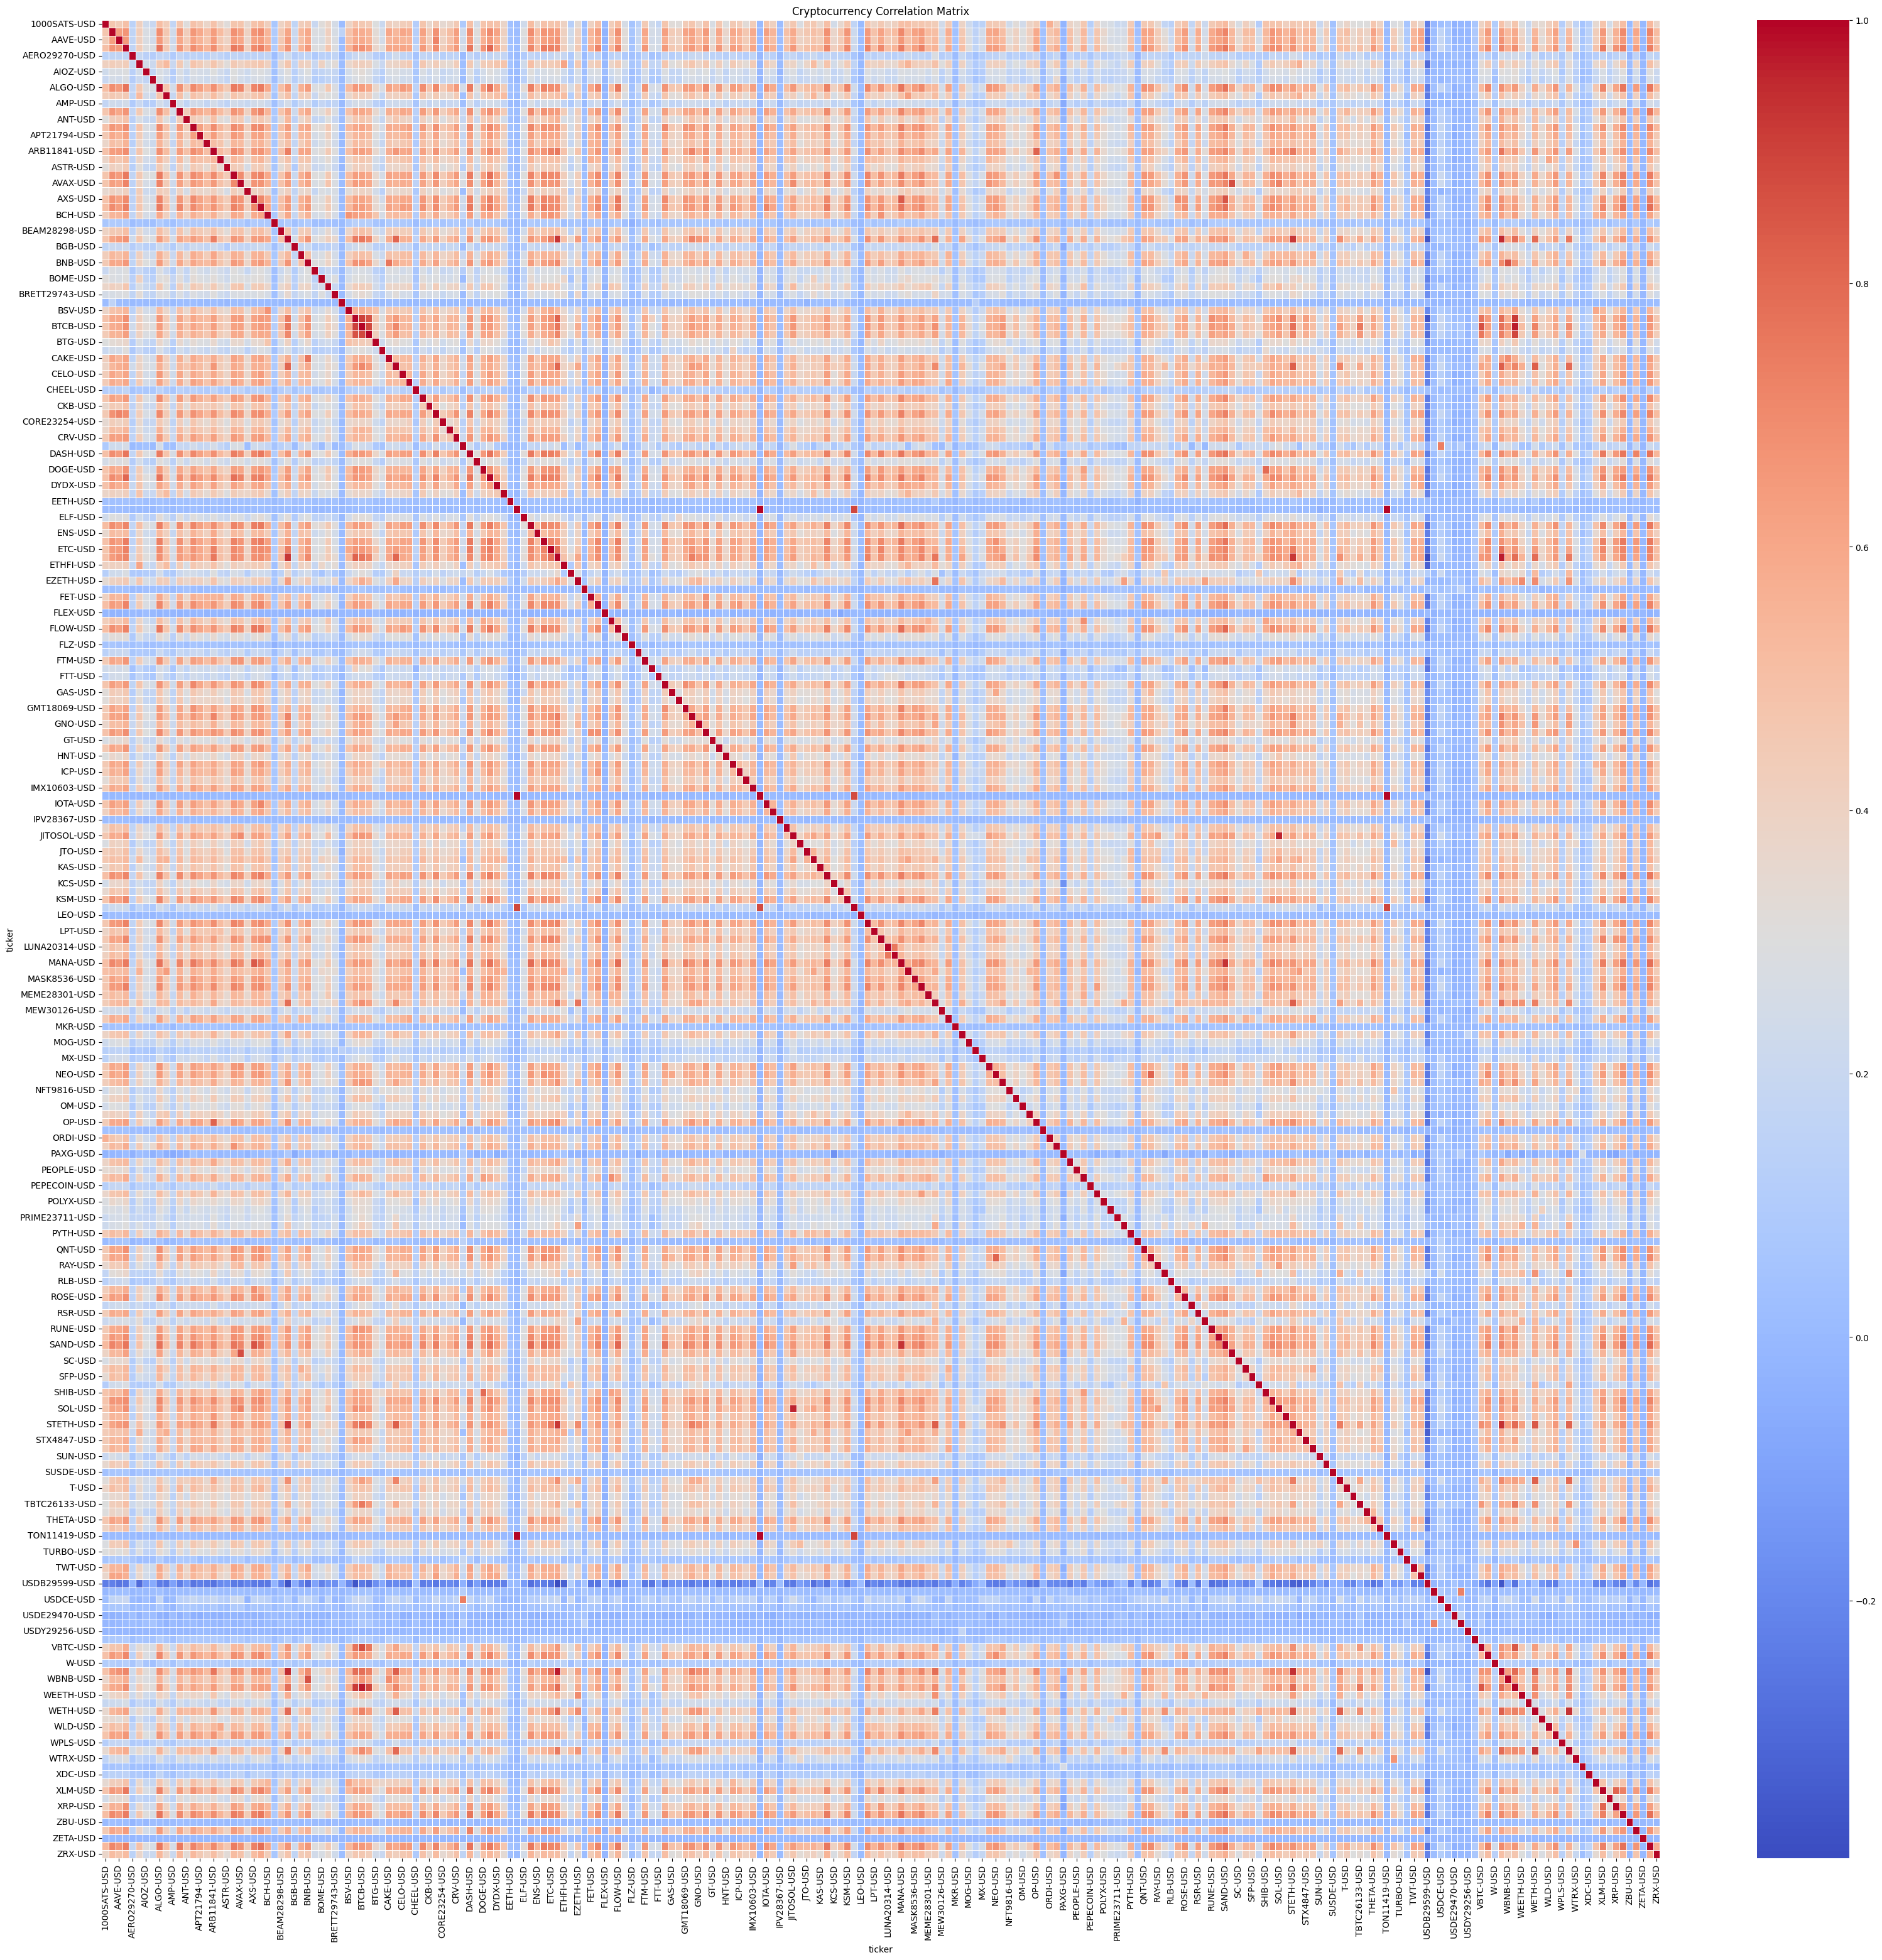

In [9]:
'''
Here we used the combined dataframe from above to create a pivot table and then
generate a correaltion matrix.
'''
pivot_data = combined_data.pivot(index='Datetime', columns='ticker', values='Daily Return')

pivot_data.sort_index

# Fill forward, then backward for any remaining NaNs
pivot_data_filled = pivot_data.ffill().bfill()

print(pivot_data_filled.head())

# Compute the correlation matrix
correlation_matrix = pivot_data_filled.corr()

# Plot a heatmap to visualize correlations
plt.figure(figsize=(40, 38))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Cryptocurrency Correlation Matrix')
plt.show()

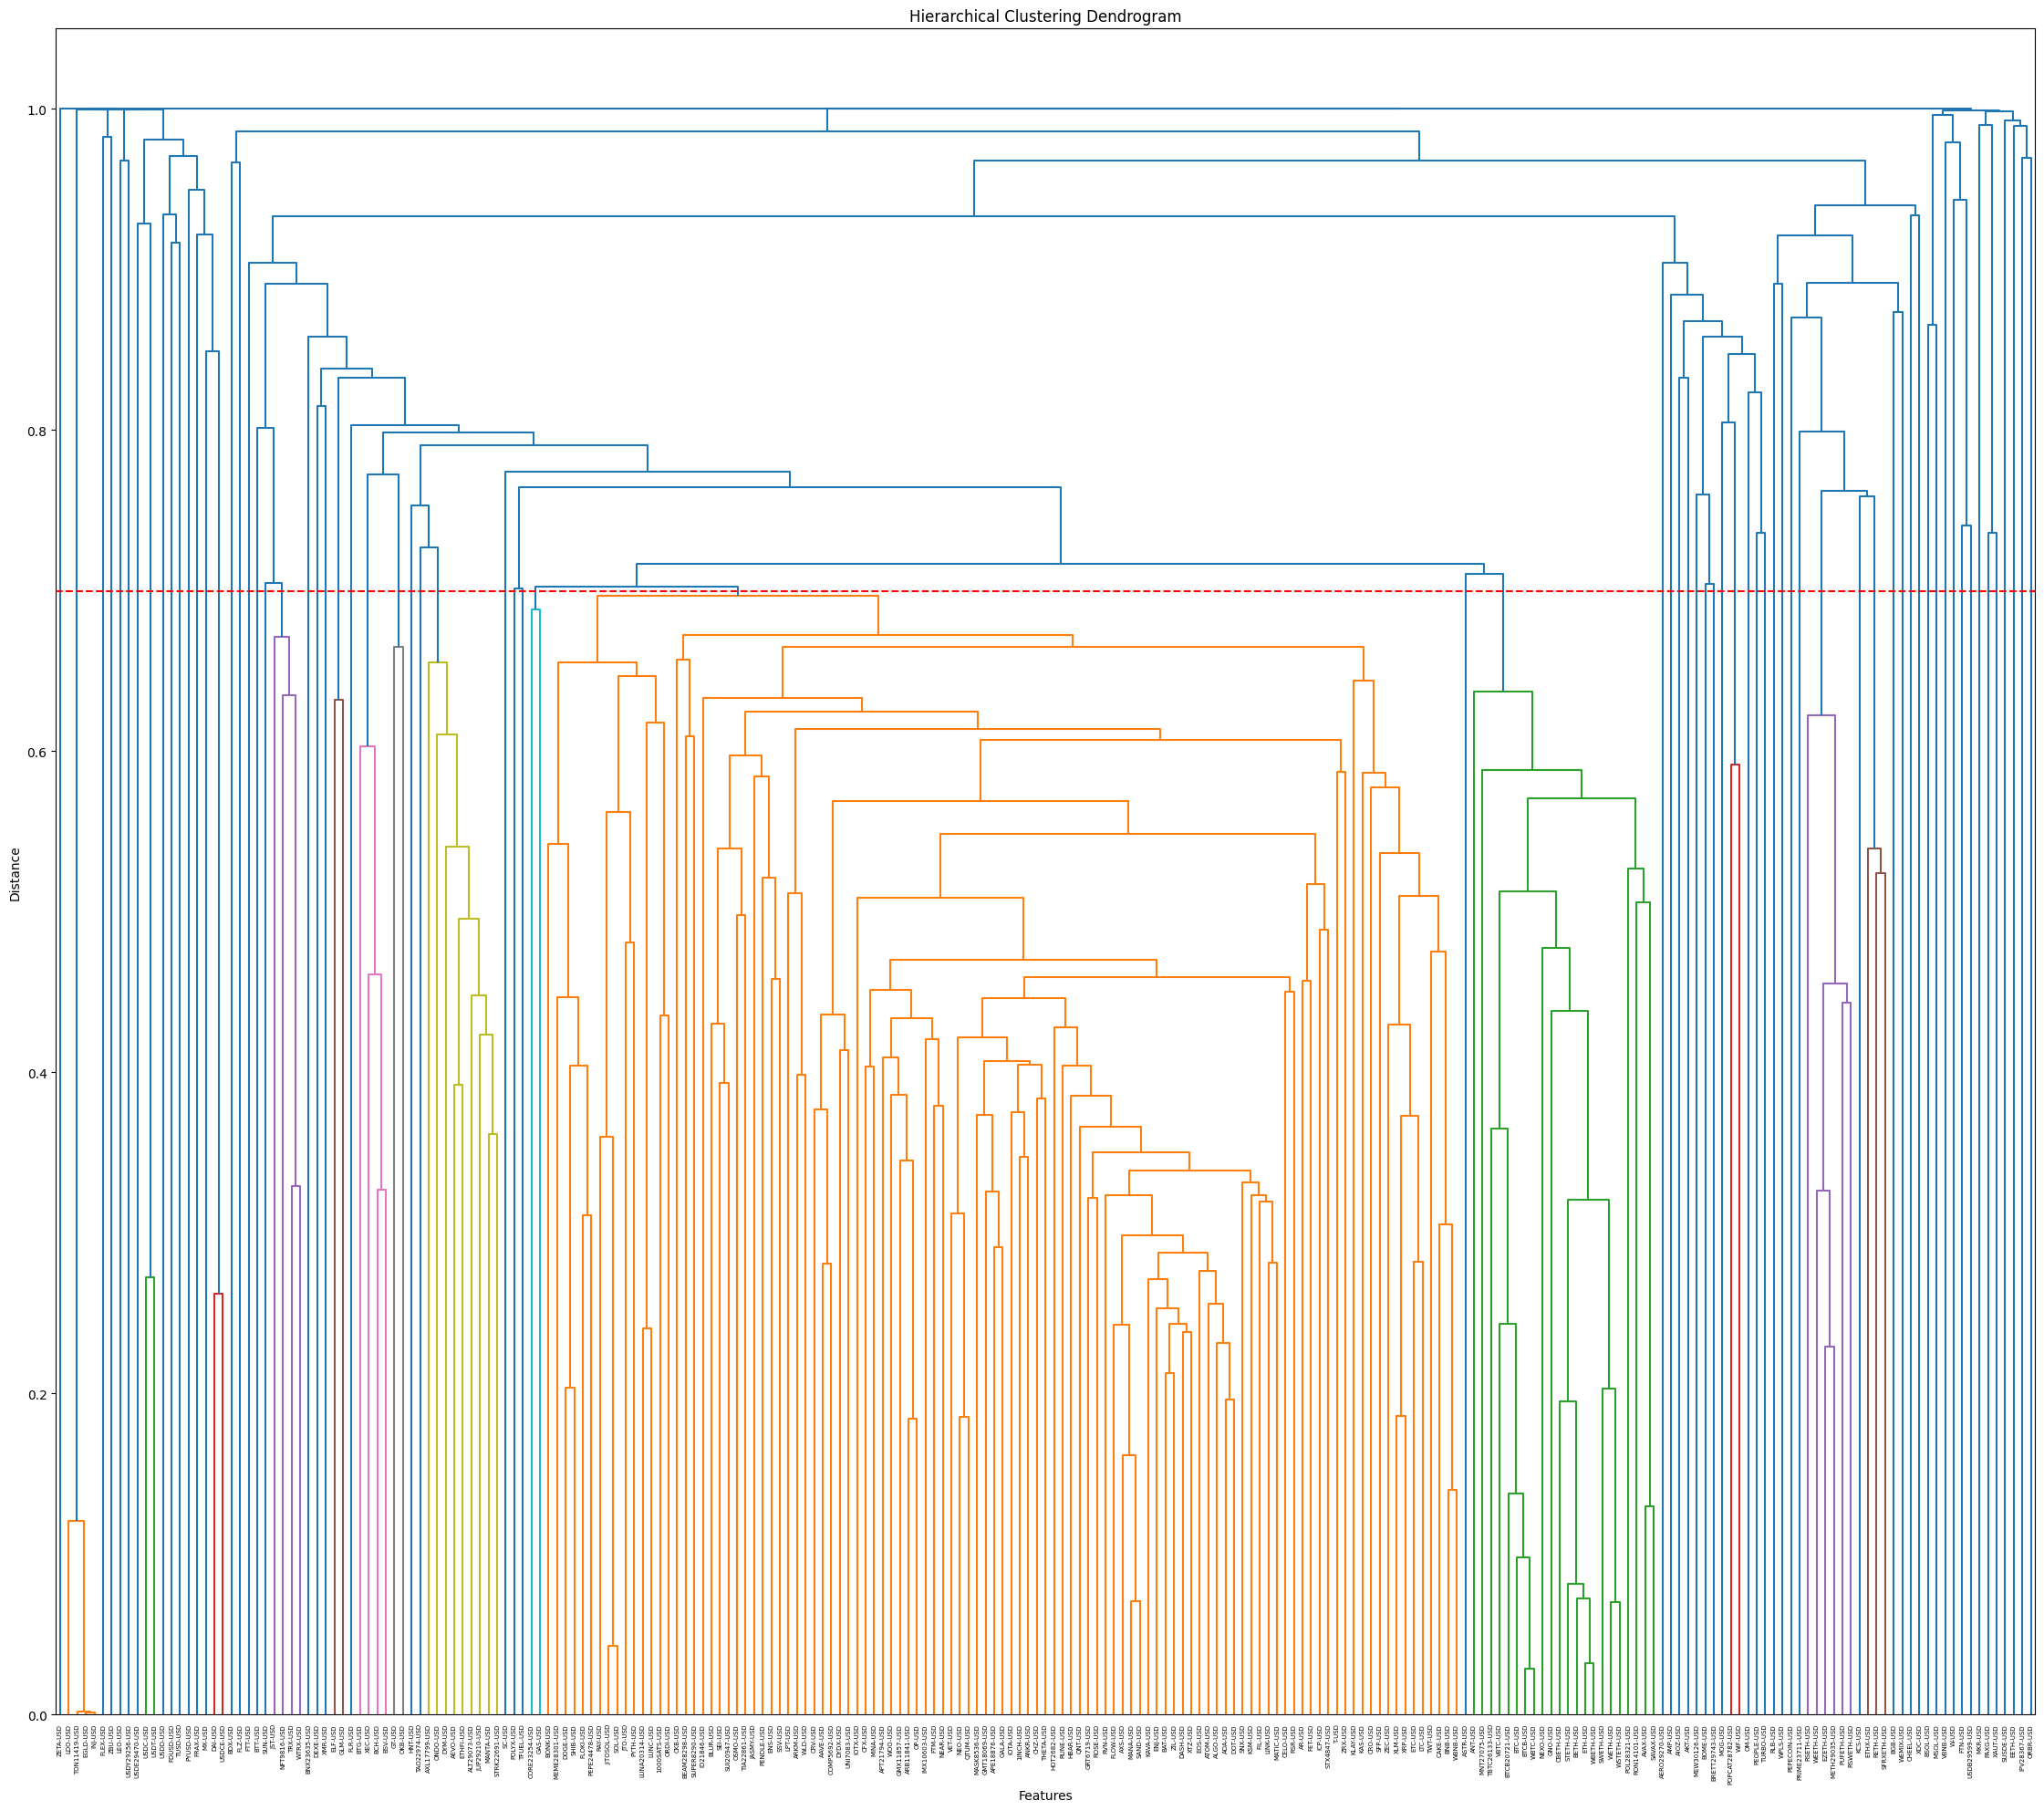

In [10]:
'''
Here using the Agglomerative algorithm, we clusterd the similar crypto-currencies with the help of
distance matrix computed using correlation matrix.
'''
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# distance matrix is calculated using the correlation matrix. As correlation value corresponds to 
# how close it is to the other ticker. Therefore, 1-corr gives the dissimilarity/distance.
dist_matrix = 1 - np.abs(correlation_matrix)

linkage_matrix = linkage(squareform(dist_matrix), method='complete')

# Plot the dendrogram
plt.figure(figsize=(28, 24))
dendrogram(linkage_matrix, labels=correlation_matrix.columns)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.axhline(y=0.6999, color='r', linestyle='--')
plt.show()

In [11]:
'''
The dendrogram is flattened to capture the clusters formed in it.
'''
from scipy.cluster.hierarchy import fcluster

labels = fcluster(linkage_matrix, 0.6999, criterion='distance')
print('Number of clusters: ', len(np.unique(labels)))

Number of clusters:  74


           Ticker  Cluster
61       EGLD-USD        1
190  TON11419-USD        1
97        INJ-USD        1
111       LDO-USD        1
74       FLEX-USD        2
..            ...      ...
126       MKR-USD       70
100  IPV28367-USD       71
139      ORBR-USD       72
60       EETH-USD       73
182     SUSDE-USD       74

[231 rows x 2 columns]


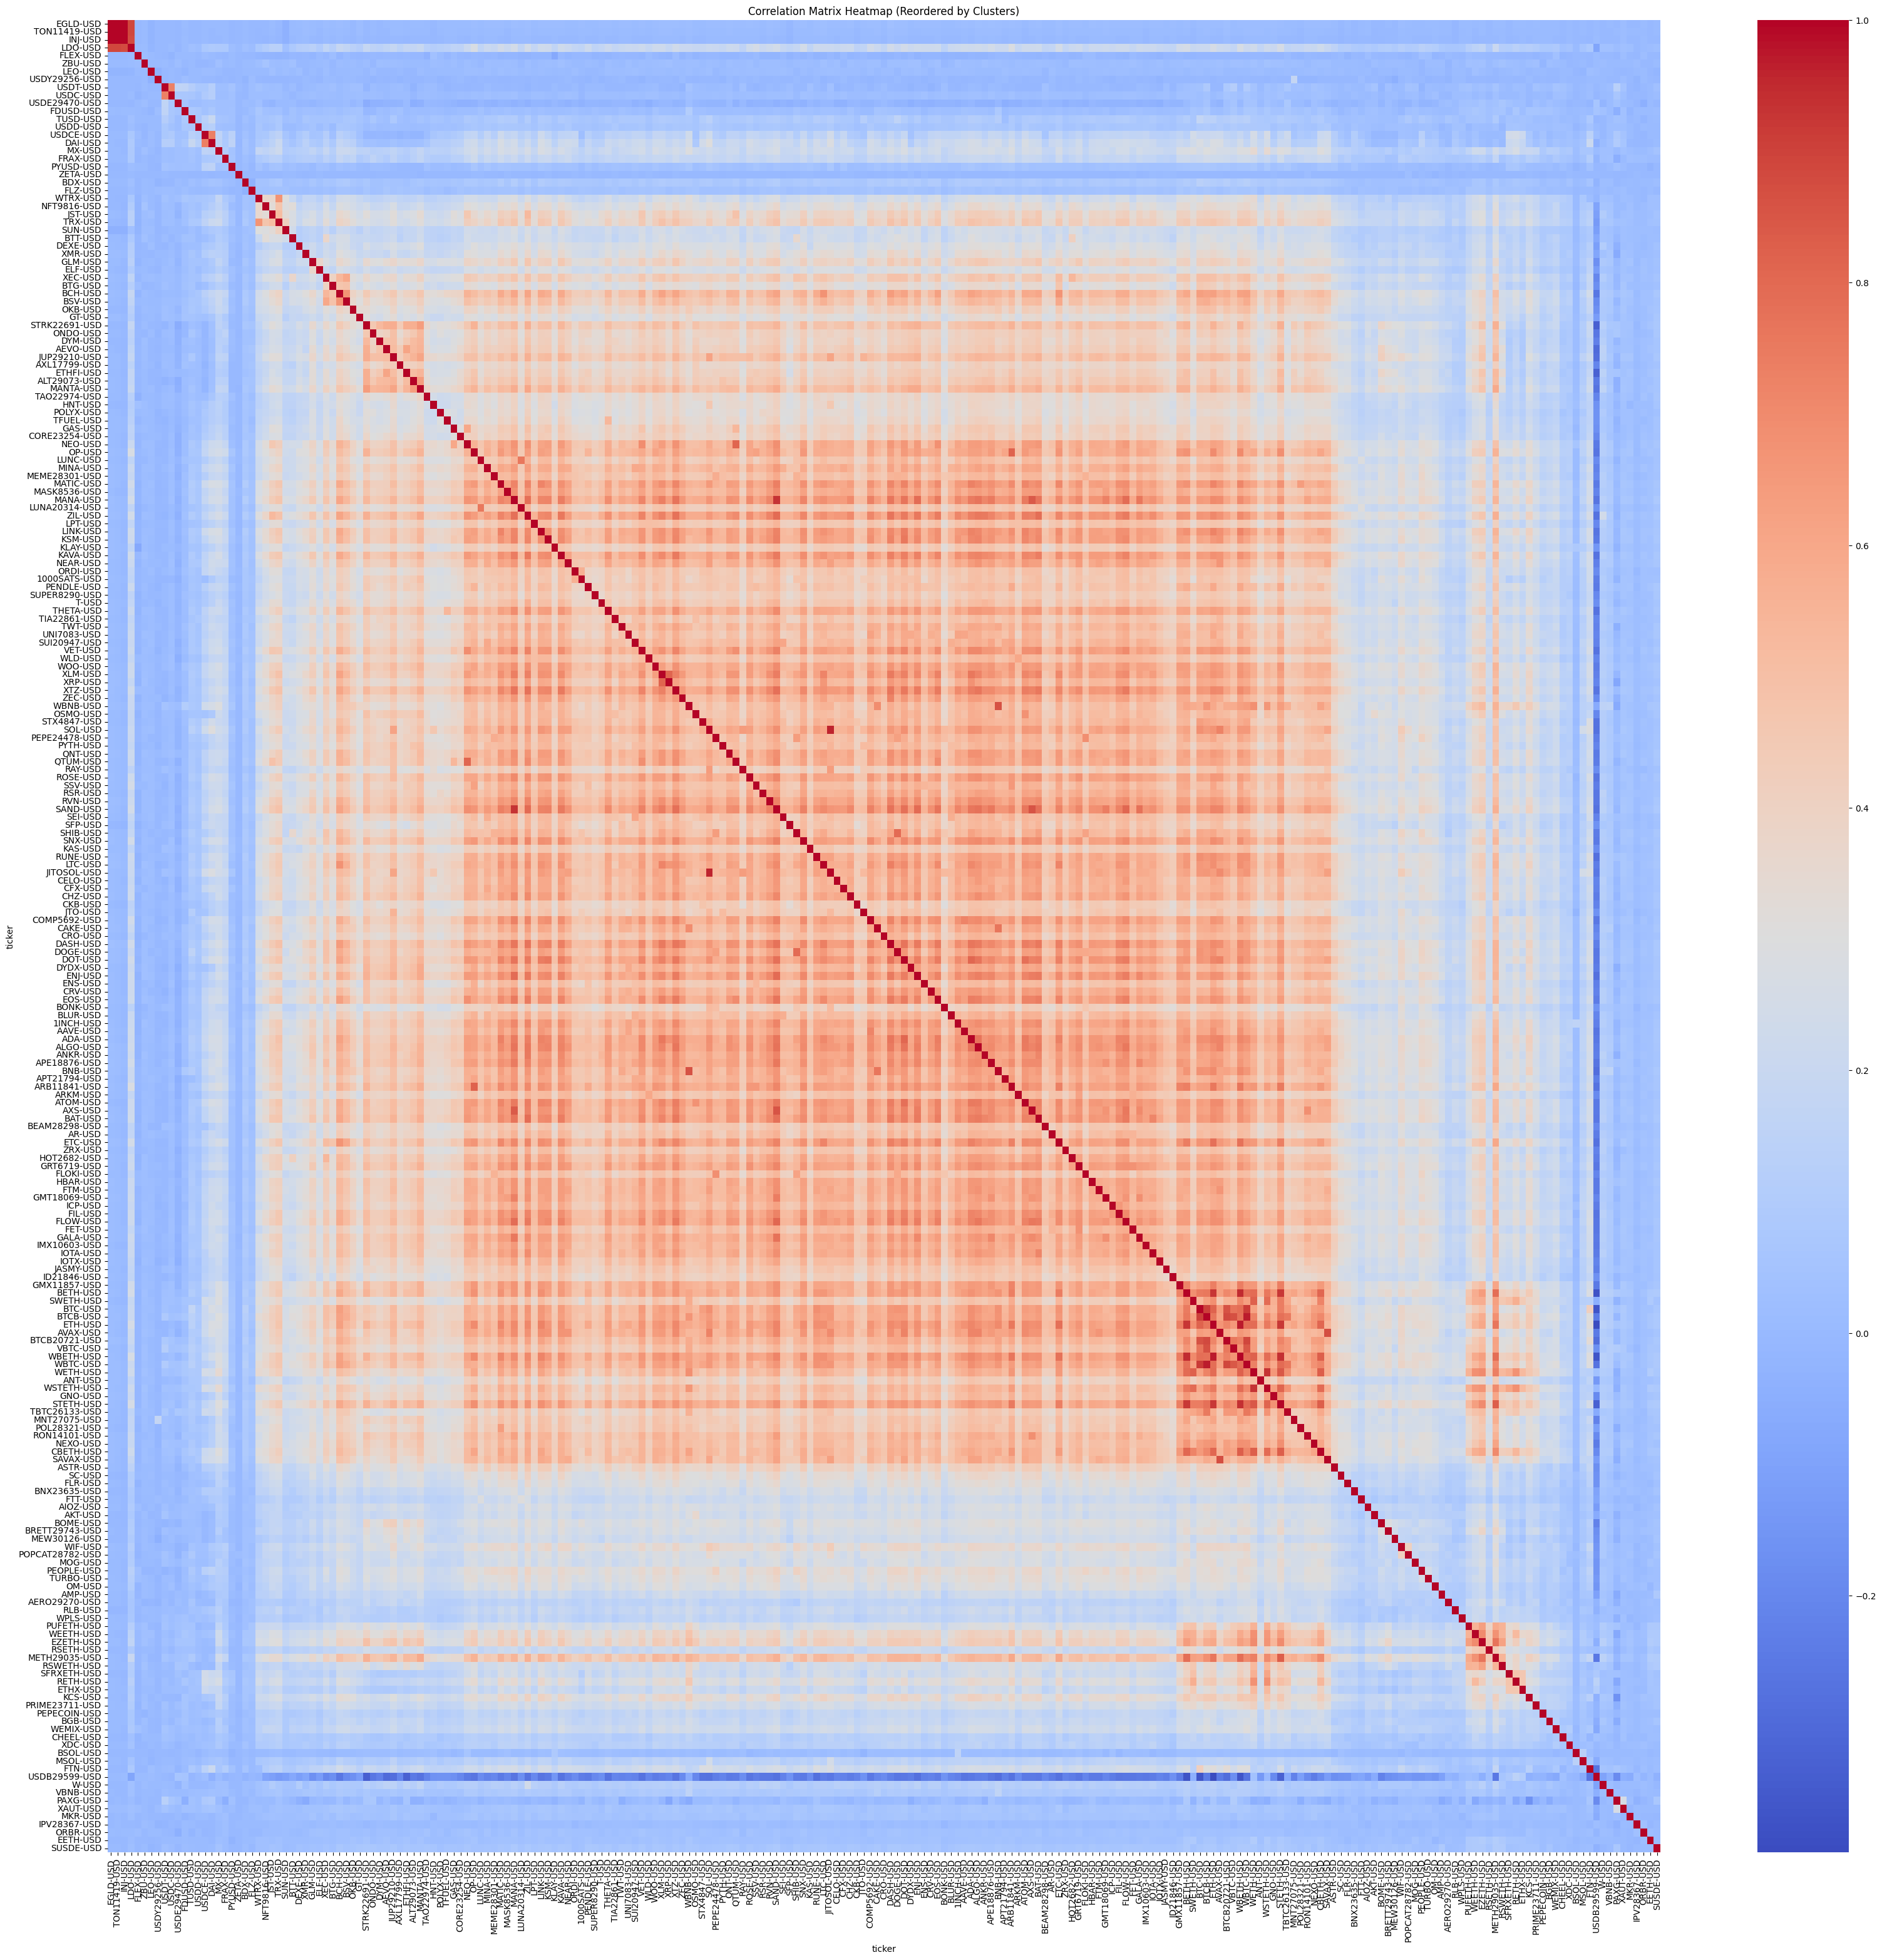

In [12]:
'''
Post capturing the labels in the above cell, we then reorderd the correlation matrix for
better visibility of heatmap
'''
import seaborn as sns
import pandas as pd

# Reorder the correlation matrix based on cluster labels
clustered_tickers = pd.DataFrame({'Ticker': correlation_matrix.columns, 'Cluster': labels})
clustered_tickers = clustered_tickers.sort_values('Cluster')
print(clustered_tickers)

reordered_corr = correlation_matrix.loc[
    clustered_tickers['Ticker'], clustered_tickers['Ticker']
]

# Plot the heatmap
plt.figure(figsize=(40, 38))
sns.heatmap(reordered_corr, cmap="coolwarm", annot=False, xticklabels=True, yticklabels=True)
plt.title("Correlation Matrix Heatmap (Reordered by Clusters)")
plt.show()

In [8]:
'''
Grouped tickers by cluster and saved the output as a table
'''
cluster_table = clustered_tickers.groupby("Cluster")["Ticker"].apply(list).reset_index()
cluster_table.columns = ["Cluster", "Tickers"]
print(cluster_table)
cluster_table.to_csv("clustered_tickers.csv", index=False)

    Cluster                                     Tickers
0         1  [EGLD-USD, TON11419-USD, INJ-USD, LDO-USD]
1         2                                  [FLEX-USD]
2         3                                   [ZBU-USD]
3         4                                   [LEO-USD]
4         5                             [USDY29256-USD]
..      ...                                         ...
69       70                                   [MKR-USD]
70       71                              [IPV28367-USD]
71       72                                  [ORBR-USD]
72       73                                  [EETH-USD]
73       74                                 [SUSDE-USD]

[74 rows x 2 columns]


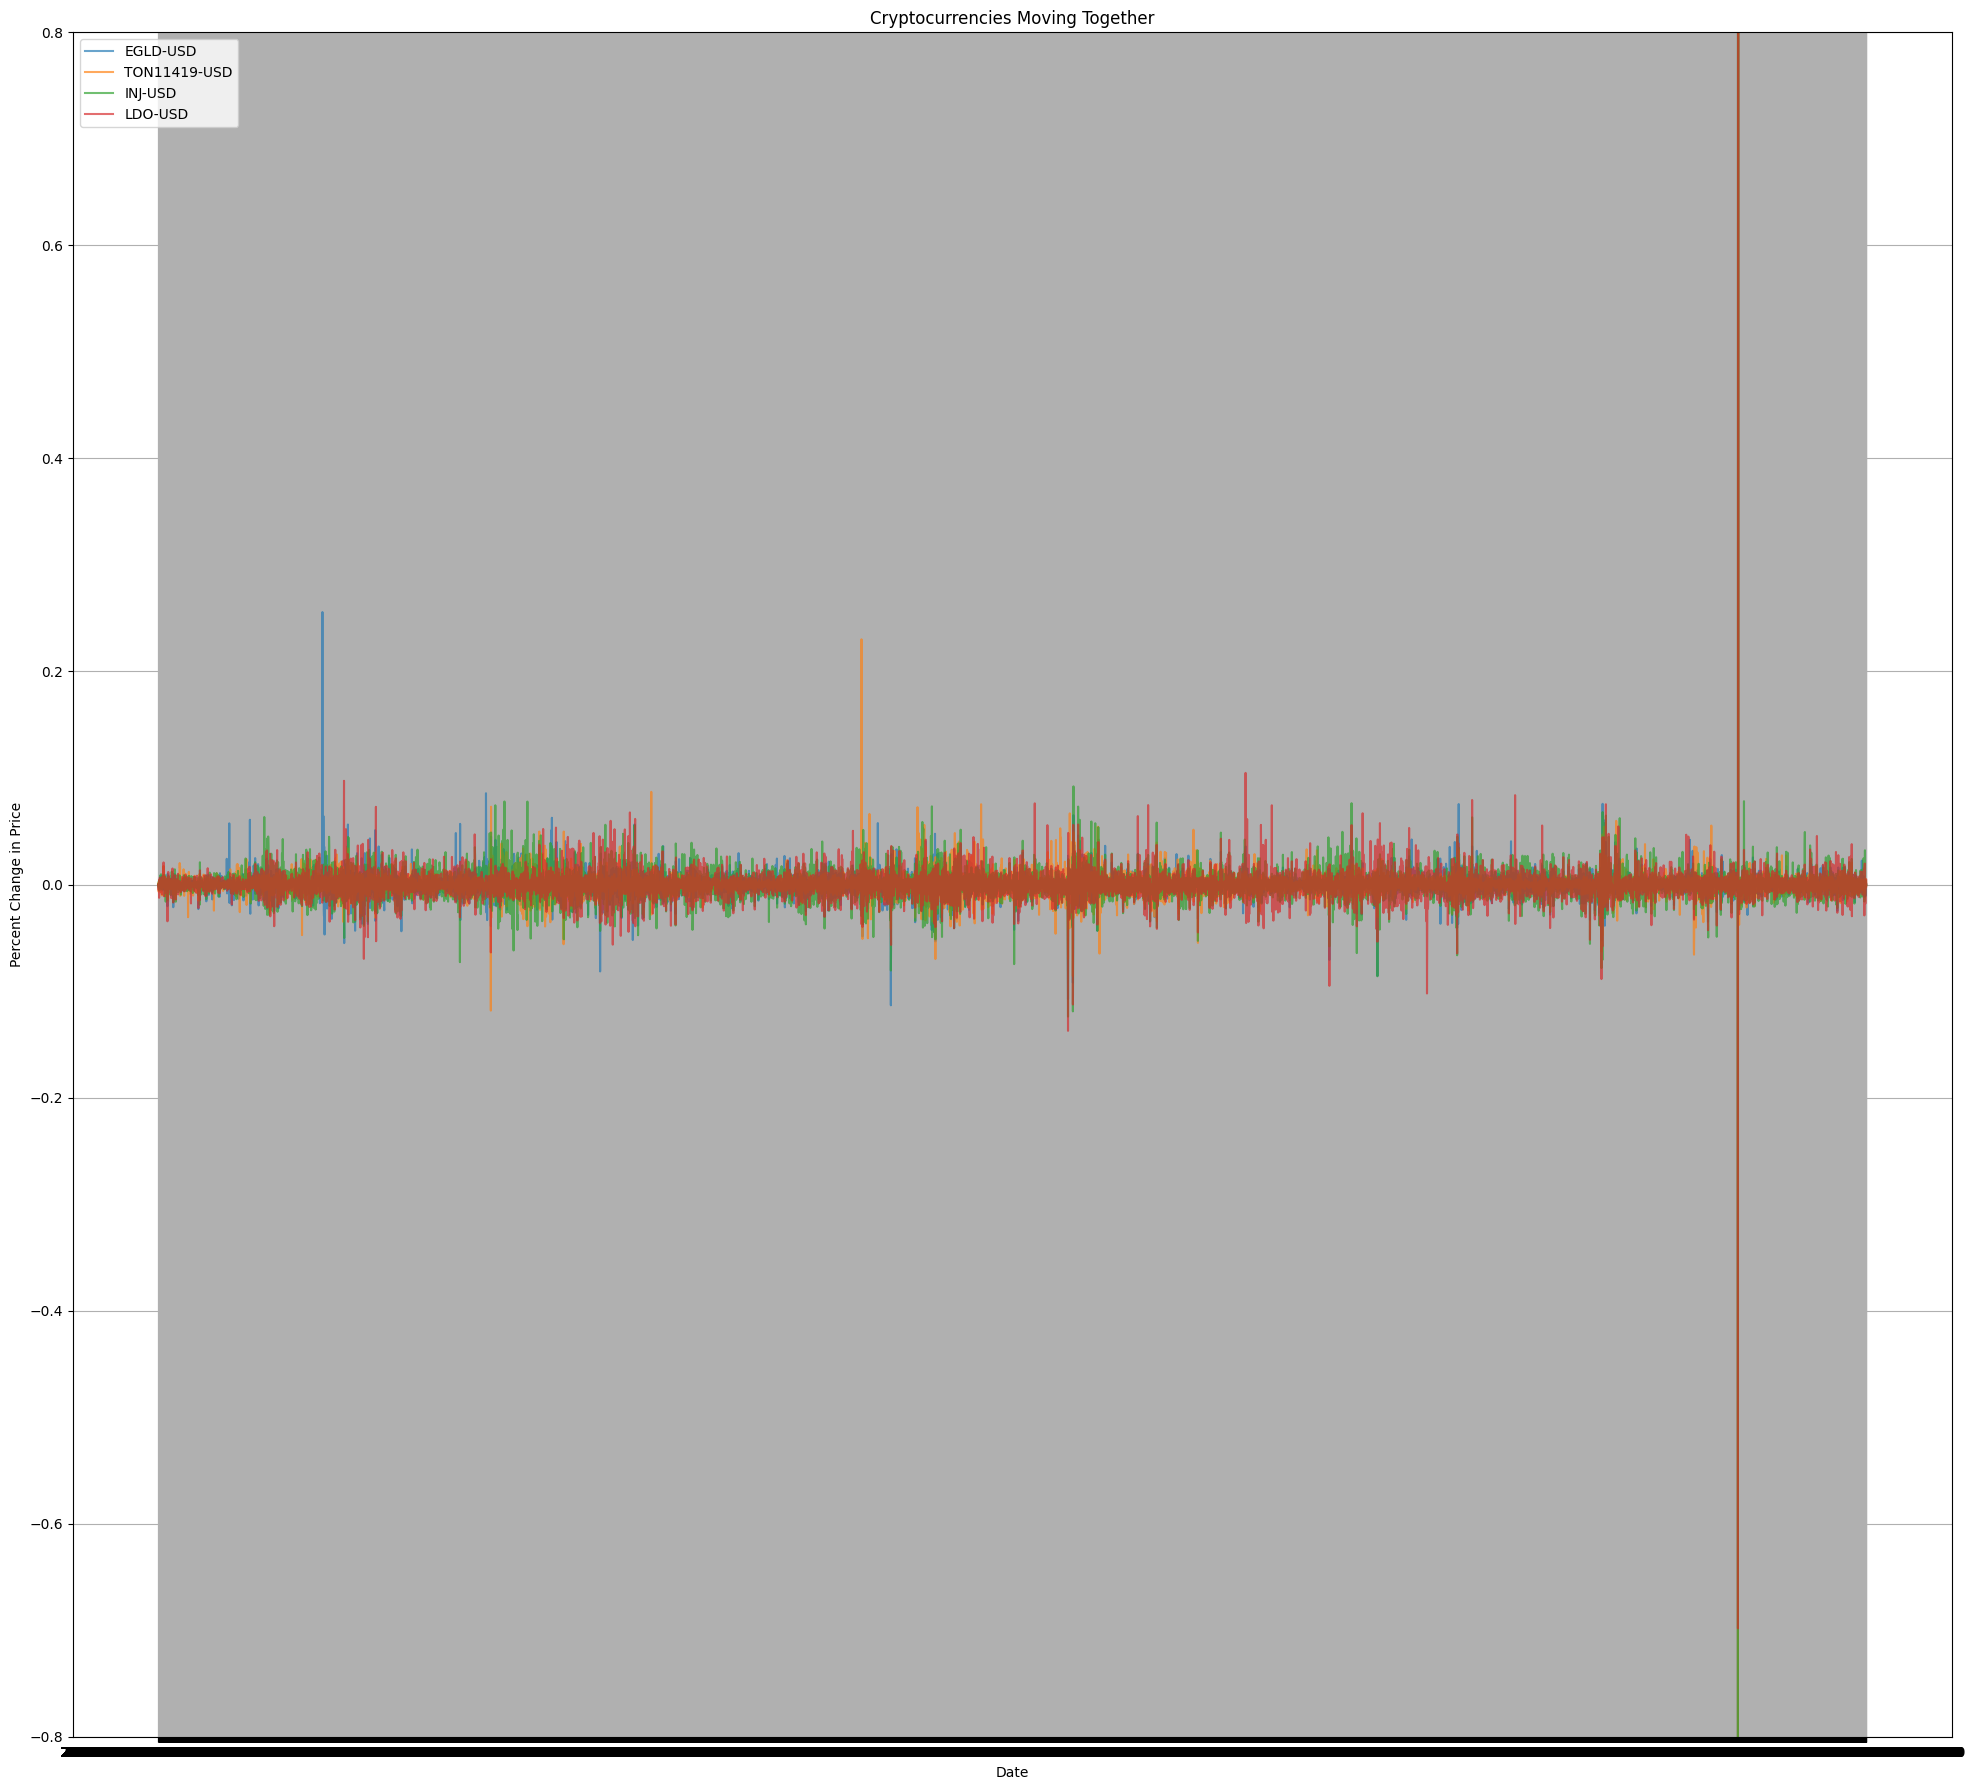

In [11]:
'''
Overlapped Time series plot for a random cluster
'''
import matplotlib.pyplot as plt

selected_cluster = ['EGLD-USD', 'TON11419-USD', 'INJ-USD', 'LDO-USD']

# Filter the time series data
cluster_data = combined_data[combined_data['ticker'].isin(selected_cluster)]
time_series_data = cluster_data.pivot(index='Datetime', columns='ticker', values='Daily Return')

# Plot the data
plt.figure(figsize=(20, 18))
for ticker in selected_cluster:
    plt.plot(time_series_data.index, time_series_data[ticker], label=ticker, alpha=0.67)
plt.title('Cryptocurrencies Moving Together')
plt.xlabel('Date')
plt.ylabel('Percent Change in Price')
plt.ylim(-0.8, 0.8)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

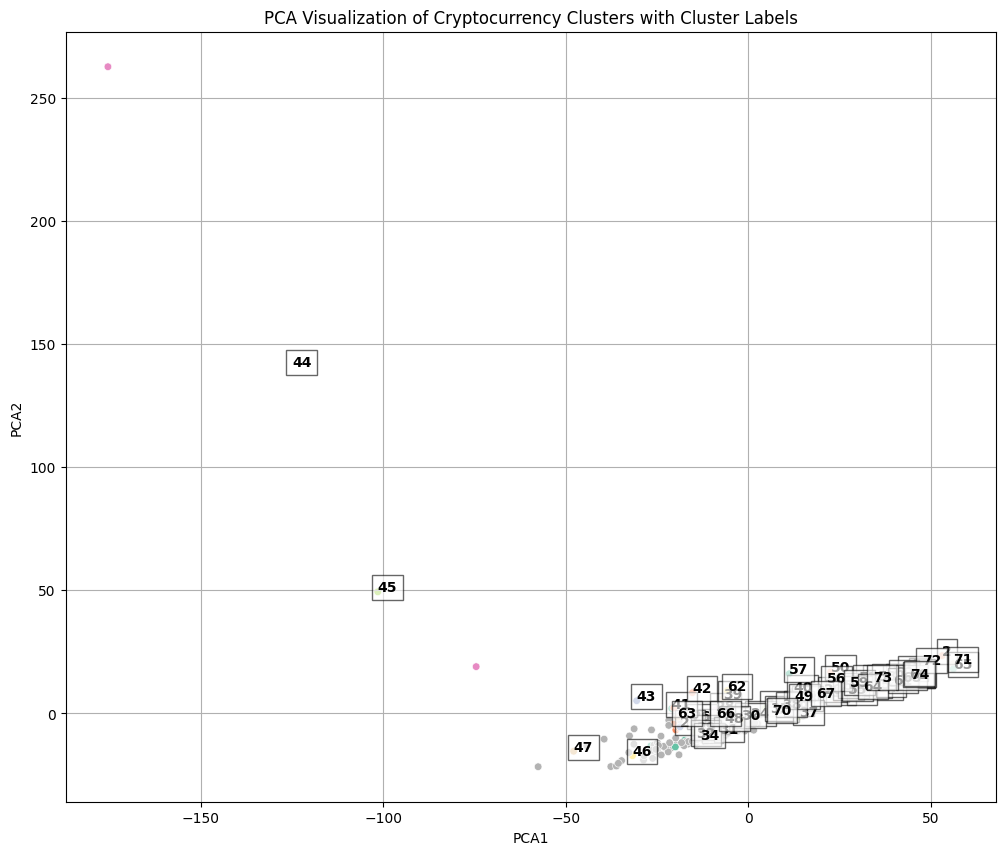

In [20]:
'''
Visulization of the clustered data using PCA
'''
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

pivot_data = combined_data.pivot(index='Datetime', columns='ticker', values='Daily Return')

pivot_data.sort_index

# Fill forward, then backward for any remaining NaNs
pivot_data_filled = pivot_data.ffill().bfill()

# Ensuring that the clustering will align with PCA by transposing the data
transposed_data = pivot_data_filled.T

# Scaling the data before applying the PCA
scaler = StandardScaler()
normalized_data = scaler.fit_transform(transposed_data)

# Appling the PCA on the scaled data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_data)

# Create a DataFrame for PCA results
df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
df['Cluster'] = labels

plt.figure(figsize=(12, 10))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='Set2', s=30, legend=None)
for cluster in sorted(set(labels)):
    cluster_points = df[df['Cluster'] == cluster]
    cluster_center = cluster_points[['PCA1', 'PCA2']].mean()
    plt.text(cluster_center['PCA1'], cluster_center['PCA2'], str(cluster), fontsize=10, fontweight='bold', bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))
plt.title('PCA Visualization of Cryptocurrency Clusters with Clustered Labels')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()

